In [1]:
from pycaret.utils import enable_colab
from pycaret.classification import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pyodbc
import warnings
warnings.filterwarnings('ignore')


enable_colab()


Colab mode enabled.


In [2]:
# Importing data from Sql Server
SERVER_NAME = 'INSPIRON7591\SQLEXPRESS'
DATABASE_NAME = 'notifications'
cnxn = pyodbc.connect("""
    Driver={{SQL Server}};
    Server={0};
    Database={1};
    Trusted_Connection=yes;""".format(SERVER_NAME, DATABASE_NAME))
query = "SELECT * FROM [notifications].[dbo].[notification_data];"
data = pd.read_sql(query, cnxn)


In [3]:
data = data[data[' timeremoved'] != 0]

data['response'] = data[' timeremoved'] - data[' timeposted']

data = data.drop([' flags'], axis=1)

data = data.drop(['user_id', ' id', ' nid'], axis=1)

data = data.drop([' timeremoved', ' timeposted'], axis=1)

data = data.drop([' default_led'], axis=1)
data = data.drop([' default_sound'], axis=1)
data = data.drop([' default_vibration'], axis=1)
data = data.drop([' vibrationpattern'], axis=1)
data = data[data['response'] > 0]
data = data[data['response'] < 1376]        #90% of the notifications have a response within 22 minutes. Response time greater than that has been filtered as outliers


In [4]:
data.response.quantile([0.25, 0.5, 0.75])


0.25     2.0
0.50     8.0
0.75    58.0
Name: response, dtype: float64

In [5]:
data.response.mean()


99.47994734120081

In [ ]:
'''

Less than median = Extremely Responsive -------------------------------- 0
Between median and 3rd Quartile = Highly Responsive -------------------- 1
Q3 to mean +(mean-Q3) = Average Responsive ----------------------------- 2
from average response till 15 minutes = Less Responsive ---------------- 3              #70% notifications in the dataset have a response time within 15 minutes
Greater than 15 minutes = Unresponsive --------------------------------- 4


'''


In [7]:
data['label'] = 0
data.label[(data['response'] > 8) & (data['response'] <= 58)] = 1
data.label[(data['response'] > 58) & (data['response'] <= 142)] = 2
data.label[(data['response'] > 142) & (data['response'] <= 900)] = 3
data.label[(data['response'] > 900)] = 4


In [8]:
le = LabelEncoder()
data[' priority'] = le.fit_transform(data[' priority'])
data[' packagename'] = le.fit_transform(data[' packagename'])


In [9]:
data = data.astype(int)


In [10]:
data.head()

,priority,packagename,sound,led,ringermode,idle,interactive,screen_state,lock_scr_notifs,response,label
9,0,0,0,0,2,0,1,2,1,7,0
12,0,0,0,0,2,0,1,2,1,1,0
13,2,39,0,0,2,0,0,1,1,564,3
15,3,136,1,1,2,0,1,2,1,31,1
19,2,70,0,0,2,0,1,2,1,33,1


In [11]:
data = data.drop(['response'], axis=1)


In [12]:
data.head()


,priority,packagename,sound,led,ringermode,idle,interactive,screen_state,lock_scr_notifs,label
9,0,0,0,0,2,0,1,2,1,0
12,0,0,0,0,2,0,1,2,1,0
13,2,39,0,0,2,0,0,1,1,3
15,3,136,1,1,2,0,1,2,1,1
19,2,70,0,0,2,0,1,2,1,1


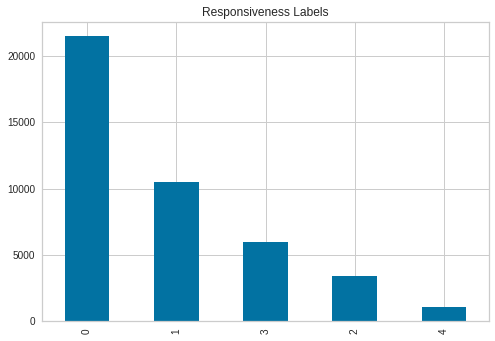

In [14]:
data['label'].value_counts().plot(kind='bar', title='Responsiveness Labels')


In [15]:
cat_cols = [" priority", " packagename", " sound", " led", " ringermode",
            " idle", " interactive", " screen_state", " lock_scr_notifs"]


In [17]:
env = setup(data=data,
            session_id=123,
            target='label',
            categorical_features=cat_cols,
            normalize=True,
            normalize_method='minmax',
            transformation=True,
            use_gpu=True,
            log_experiment=True,
            experiment_name='notification',
            fix_imbalance=True,
            silent=True)


,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(42538, 10)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [25]:
compare_models()    # Stratified 10 folds cross validation


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9867,0.9980,0.8930,0.9735,0.9305,0.9232,0.9248,1.104
lightgbm,Light Gradient Boosting Machine,0.9867,0.9980,0.8864,0.9804,0.9294,0.9221,0.9245,0.127
gbc,Gradient Boosting Classifier,0.9854,0.9972,0.9024,0.9514,0.9251,0.9171,0.9181,0.371
et,Extra Trees Classifier,0.9848,0.9903,0.8582,0.9894,0.9184,0.9101,0.9133,1.136
dt,Decision Tree Classifier,0.9790,0.9449,0.9021,0.8968,0.8974,0.8857,0.8870,0.018
ada,Ada Boost Classifier,0.9698,0.9808,0.8020,0.8915,0.8406,0.8241,0.8277,0.204
lr,Logistic Regression,0.9654,0.9721,0.7385,0.9055,0.8113,0.7925,0.7987,0.074
svm,SVM - Linear Kernel,0.9603,0.0000,0.6967,0.8942,0.7776,0.7563,0.7665,0.021
knn,K Neighbors Classifier,0.9565,0.9453,0.5742,0.9887,0.7229,0.7014,0.7337,0.237
lda,Linear Discriminant Analysis,0.9403,0.9614,0.5621,0.7803,0.6510,0.6196,0.6308,0.035


In [27]:
# Stratified 10 folds cross validation
rf = create_model('rf', fold=10, round=4)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9905,0.9992,0.9032,1.0000,0.9492,0.9439,0.9454
1,0.9905,0.9989,0.9355,0.9667,0.9508,0.9455,0.9457
2,0.9810,0.9966,0.8125,1.0000,0.8966,0.8862,0.8920
3,0.9778,0.9987,0.8750,0.9032,0.8889,0.8765,0.8767
4,0.9810,0.9965,0.8438,0.9643,0.9000,0.8895,0.8919
5,0.9873,0.9967,0.8750,1.0000,0.9333,0.9264,0.9289
6,0.9968,0.9998,1.0000,0.9697,0.9846,0.9828,0.9830
7,0.9810,0.9973,0.8438,0.9643,0.9000,0.8895,0.8919
8,0.9905,0.9998,0.9062,1.0000,0.9508,0.9456,0.9470
9,0.9904,0.9963,0.9355,0.9667,0.9508,0.9455,0.9457


In [26]:
# Stratified 10 folds cross validation
tuned_rf = tune_model(rf, optimize='Accuracy')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9841,0.9981,0.8387,1.0000,0.9123,0.9036,0.9079
1,0.9714,0.9960,0.8710,0.8438,0.8571,0.8413,0.8414
2,0.9841,0.9972,0.8750,0.9655,0.9180,0.9093,0.9106
3,0.9810,0.9822,0.8438,0.9643,0.9000,0.8895,0.8919
4,0.9841,0.9506,0.8438,1.0000,0.9153,0.9066,0.9106
5,0.9778,0.9810,0.9062,0.8788,0.8923,0.8799,0.8801
6,0.9841,0.9990,0.9688,0.8857,0.9254,0.9165,0.9177
7,0.9873,0.9673,0.9062,0.9667,0.9355,0.9284,0.9290
8,0.9873,0.9982,0.9062,0.9667,0.9355,0.9284,0.9290
9,0.9745,0.9779,0.8710,0.8710,0.8710,0.8568,0.8568


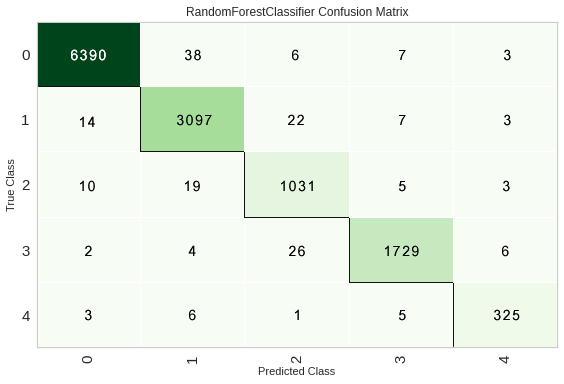

In [18]:
plot_model(tuned_rf, plot='confusion_matrix')


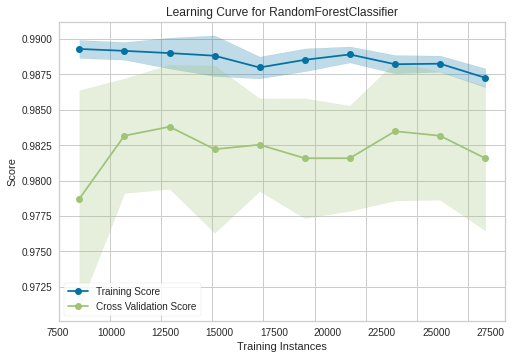

In [19]:
plot_model(tuned_rf, plot='learning')


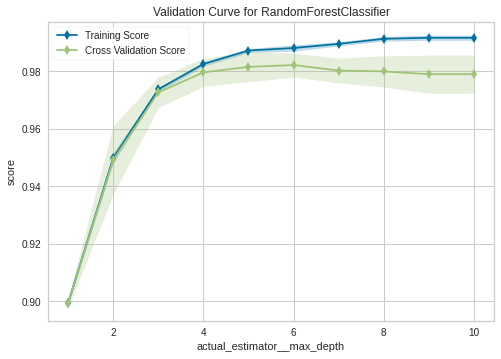

In [20]:
plot_model(tuned_rf, plot='vc')


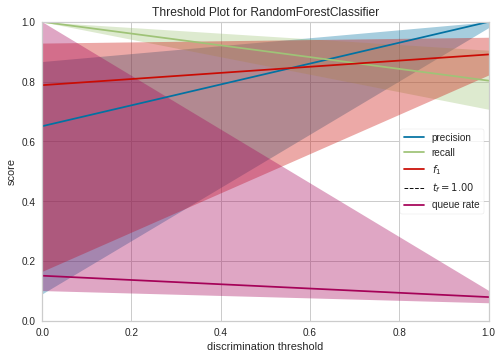

In [21]:
plot_model(tuned_rf, plot='threshold')
